#Projet: Simulation d'un MB et d'un MB Géométrique

Objectif: Simuler et visualiser les trajectoires:
- d’un mouvement brownien standard W_t (modélisation du bruit aléatoire),
- d’un mouvement brownien géométrique S_t (modèle classique de l’évolution d’un prix d’actif).

But:
- Comprendre l’impact du drift et de la volatilité sur la trajectoire d’un actif.
- Observer la croissance moyenne et l’incertitude dans un modèle log-normal comme Black-Scholes.

Paramètres modifiables:
- T : durée totale de la simulation (ex. 1 an)
- N : nombre de pas de temps (discrétisation de [0, T])
- n_paths : nombre de trajectoires générées
- S0 : prix initial de l’actif
- mu : drift (croissance moyenne attendue de l’actif)
- sigma : volatilité (amplitude des fluctuations autour du drift)

---
#I) Importations des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

---
#II) On définit tous les paramètres:

- T: horizon temporel de la simulation (en année)
- N: nombre de pas de temps (plus il est grand, plus la trajectoire est précise)
- n_paths: nombre de trajectoires simulées
- S0: prix initial de l’actif
- mu: drift
- sigma: volatilité (amplitude des fluctuations autour du drift)

In [2]:
T = 1.0
N = 500
dt = T / N
t = np.linspace(0, T, N+1)  #Explication a)
n_paths = 10

S0 = 100
mu = 0.05
sigma = 0.2

##a) Construction de la grille de temps avec `np.linspace(0, T, N+1)`

Cette instruction permet de créer une grille discrète de temps que l’on utilise pour simuler les trajectoires d’un processus stochastique comme \( W_t \) ou \( S_t \).  
Voici ce que signifie chaque élément :

- `np.linspace(a, b, n)` génère un tableau de `n` points **uniformément espacés** entre `a` et `b`, **inclusivement**.
- Ici, on écrit `np.linspace(0, T, N+1)` donc :
  - `a = 0` : on commence la simulation à \( t = 0 \),
  - `b = T` : on la termine à \( t = T \),
  - `n = N+1` : on veut **N pas de temps**, donc **N+1 points** sur la grille.

Pourquoi faut-il N+1 points ?
Parce qu’un pas de temps est un intervalle entre deux points.  
Donc si on veut **N intervalles**, il faut **N+1 extrémités** :

$$
\text{grille de temps :} \quad t_0 = 0,\ t_1,\ t_2,\ \ldots,\ t_N = T
$$

Cela garantit que chaque pas a une taille constante, appelée pas de discrétisation :

$$
\Delta t = \frac{T}{N}
$$

Exemple :
Si on prend :
- \( T = 1 \) (soit 1 an),
- \( N = 4 \) (4 pas de temps),

alors on écrit :  
```python
np.linspace(0, 1, 5)


---
#III) On génère les trajectoires du mouvement brownien standard

In [3]:
np.random.seed(1)                                            #Explication a)
dWt = np.random.normal(0, np.sqrt(dt), size=(n_paths, N))    #Explication b)
Wt = np.zeros((n_paths, N+1))                                #Explication c)
Wt[:, 1:] = np.cumsum(dWt, axis=1)                           #Explication d)

##a) Contrôle de l'aléa avec `np.random.seed(1)`

La fonction `np.random.seed(1)` permet de **fixer la graine du générateur de nombres aléatoires** de NumPy.

En fixant une graine avec `np.random.seed(k)` :
- on initialise le générateur pseudo-aléatoire avec une valeur déterministe `k`,
- on obtient **toujours la même suite de nombres aléatoires** à chaque exécution.

##b) Pourquoi sqrt(dt) dans NumPy ?

En théorie, un incrément du mouvement brownien standard $ \mathrm(dW_t) $ est défini comme suit :

$$ dW_t = W_{t + \Delta t} - W_t \sim \mathrm{N}(0, \Delta t) $$

C’est-à-dire :
$$ \mathbb{E}[dW_t] = 0 $$

$$ \mathrm{Var}(dW_t) = \Delta t $$

Mais la fonction `np.random.normal` attend **l’écart-type** (et non la variance) comme deuxième argument !

##c) Initialisation de la matrice `Wt` avec des zéros : `Wt = np.zeros((n_paths, N+1))`

On initialise ici une matrice `Wt` qui contiendra **toutes les trajectoires simulées du mouvement brownien**,  
avec un total de `n_paths` trajectoires et `N+1` points de temps sur l’intervalle \([0, T]\).

### Pourquoi `N+1` ?
Parce qu’on simule \( N \) pas de temps, donc \( N+1 \) points sur la grille \( t_0, t_1, ..., t_N \), incluant \( W_0 = 0 \).

### Pourquoi des zéros ?
- Le mouvement brownien commence par définition à zéro : \( W_0 = 0 \),
- En initialisant toute la matrice à zéro, on garantit que la première colonne (i.e. tous les \( W_0 \)) est correcte,
- Ensuite, on remplira les colonnes suivantes avec les valeurs cumulées des incréments simulés \( dW_t \).

### Résultat :
On obtient une matrice `Wt` de taille `(n_paths, N+1)` prête à contenir chaque trajectoire complète \( (W_0, W_{t_1}, ..., W_T) \).


##d) Remplissage de la trajectoire brownienne avec `Wt[:, 1:] = np.cumsum(dWt, axis=1)`

On remplit ici la matrice `Wt` avec les trajectoires du mouvement brownien, en sommant cumulativement les incréments simulés dans `dWt`.

### Détail de la syntaxe :

- `np.cumsum(dWt, axis=1)` : effectue la **somme cumulée** des incréments le long de l’axe du temps.
  - Cela produit une matrice où chaque ligne contient :
    $$ [dW_1,\ dW_1 + dW_2,\ dW_1 + dW_2 + dW_3,\ \ldots] $$

  - Ce sont les valeurs successives de \( W_t \) **à partir de \( t_1 \)** car \( W_0 = 0 \) est déjà en place.

- `Wt[:, 1:]` : sélectionne toutes les lignes de la matrice `Wt` (toutes les trajectoires),  
  mais seulement à partir de la **deuxième colonne** (c’est-à-dire les colonnes \( t_1 \) à \( t_N \)).

### Pourquoi on ne remplit pas la colonne 0 ?
Parce qu’elle contient déjà \( W_0 = 0 \) (ajouté lors de l’étape précédente avec `np.zeros(...)`).

### Résultat :
La matrice `Wt` contient désormais, pour chaque trajectoire :

$$
[W_0 = 0,\ W_{t_1},\ W_{t_2},\ \ldots,\ W_T]
$$

où chaque valeur \( W_{t_k} \) est la somme cumulée des incréments \( dW \).


---
#IV) On génère les trajectoires du mouvement brownien géométrique

In [5]:
#À partir des trajectoires de W_t, on génère ici les trajectoires du mouvement brownien géométrique S_t

S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * Wt)

##a) Construction du mouvement brownien géométrique avec la formule de Black-Scholes

On utilise ici les trajectoires simulées de \( W_t \) pour générer un **mouvement brownien géométrique** \( S_t \),  
modélisant l’évolution d’un actif financier dans le modèle de Black-Scholes.

La formule utilisée est :

$$
S_t = S_0 \cdot \exp\left( \left( \mu - \frac{1}{2}\sigma^2 \right)t + \sigma W_t \right)
$$


### Interprétation:

- Le terme $$ \left( \mu - \frac{1}{2} \sigma^2 \right)t $$ vient du **drift corrigé** dans la solution exacte de l’équation différentielle stochastique (selon Itô).
- Le terme $$ \sigma W_t $$ ajoute l’effet **aléatoire**, proportionnel à la volatilité et au bruit brownien.
- Le modèle suppose que \( \ln(S_t) \) suit une loi normale :  
  $$ \ln(S_t) \sim \mathrm{N}\left( \ln(S_0) + \left(\mu - \frac{1}{2} \sigma^2\right)t,\ \sigma^2 t \right) $$


---
#V) Graphique

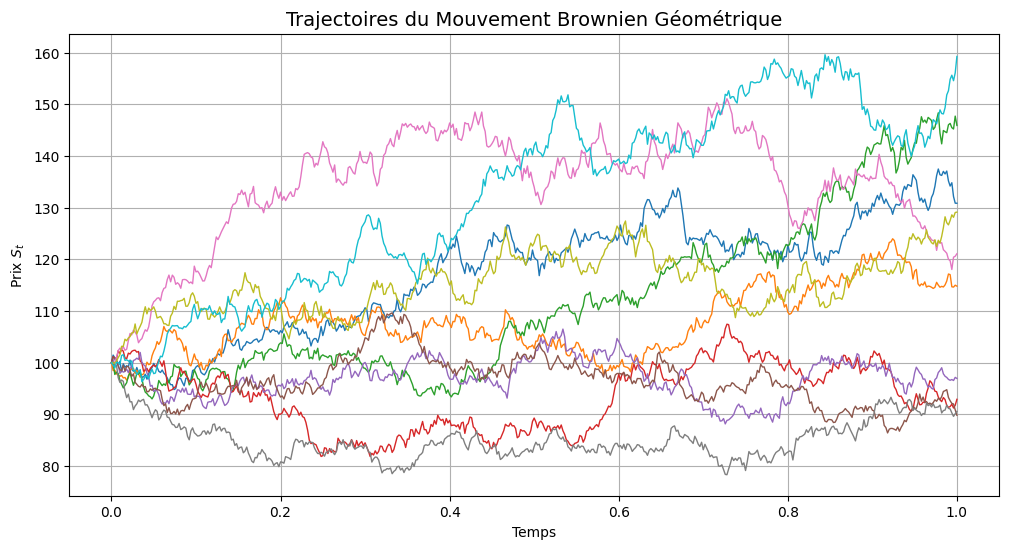

In [11]:
plt.figure(figsize=(12, 6))
for i in range(n_paths):
    plt.plot(t, S[i], lw=1)
plt.title("Trajectoires du Mouvement Brownien Géométrique", fontsize=14)
plt.xlabel("Temps")
plt.ylabel("Prix $S_t$")
plt.grid(True)